# Australia - Antarctica spreading rates

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pygplates
import numpy as np
import csv

from velocities_by_plate_id import calculate_velocities
from velocities_by_plate_id import calculate_velocities_along_reconstructed_geometry
from velocities_by_plate_id import calculate_velocities_over_time

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

ModuleNotFoundError: No module named 'pygplates'

In [3]:
rotation_filename = 'Data/Matthews_etal_GPC_2016_410-0Ma_GK07.rot'
reconstruction_feature = 'Data/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz'

australia_plateID = 801

anchor_plate = 0


In [4]:
reconstruction_time = 140 # Ma

reconstructed_shapefile = "reconstruction_{:3.0f}.shp"

pygplates.reconstruct(reconstruction_feature, \
                      rotation_filename, \
                      reconstructed_shapefile.format(reconstruction_time), \
                      reconstruction_time)



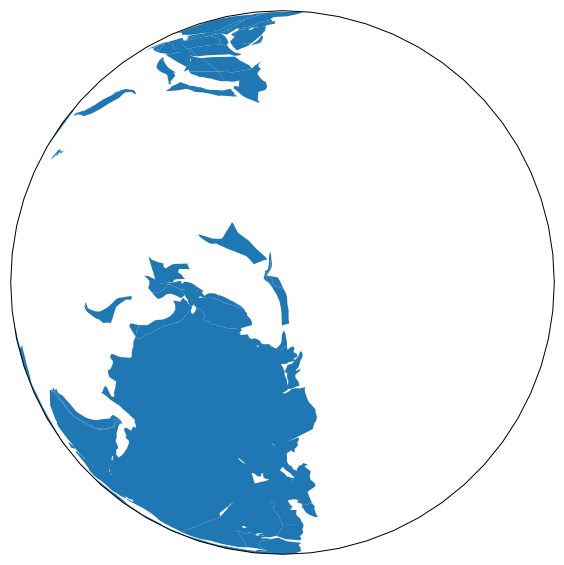

In [5]:
# proj = ccrs.NearsidePerspective(140, -40, satellite_height=4e6)
proj = ccrs.Orthographic(140,-40)
# proj = ccrs.AzimuthalEquidistant(140, -40, )

shp = shpreader.Reader(reconstructed_shapefile.format(reconstruction_time)).geometries()
ft  = cfeature.ShapelyFeature(shp, ccrs.PlateCarree())


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=proj)
ax.add_feature(ft)

In [1]:
import pandas as pd
#Gplates_spreadingrates=
Gplates_SR=pd.read_csv('./Gplates_AnAu.csv')
#print Gplates_SR.columns
df = pd.DataFrame(Gplates_SR, columns = Gplates_SR.columns)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 10: invalid start byte

In [7]:
SW_coast=pd.read_csv('./Southern_AUcoast.csv', header=None)

In [8]:
points_downunder = np.array(SW_coast)
#points_downunder can be any array, for example a bunch of points along the SE coast of Australia in this case
npts = points_downunder.shape[0]
# create point features
point_features = []
for lon, lat in points_downunder:
    point_feature = pygplates.Feature()
    point_feature.set_geometry(pygplates.PointOnSphere(lat, lon))
    point_feature.set_reconstruction_plate_id(australia_plateID)
    point_features.append(point_feature)


reconstruction_times = np.arange(0, 140, 1) # Ma

lons_out = np.empty((reconstruction_times.size, npts))
lats_out = np.empty((reconstruction_times.size, npts))
vels_out = np.empty((reconstruction_times.size, npts))

for t, reconstruction_time in enumerate(reconstruction_times):
    out_data = calculate_velocities(rotation_filename, point_features, 1, reconstruction_time, anchor_plate_id=802)
    tlon, tlat, vel, ovel, arc, oarc, plateID = np.array(out_data).T
    
    lons_out[t] = tlon
    lats_out[t] = tlat
    vels_out[t] = vel


In [9]:
r,c=vels_out.shape #row, col
#Calculating the min, mean and max velocities for all the points at each of the time steps
vels_matrix=np.zeros((r,3))
for i in range(0,r,1):
    vels_matrix[i,0]=np.min(vels_out[i,:])
    vels_matrix[i,1]=np.mean(vels_out[i,:])
    vels_matrix[i,2]=np.max(vels_out[i,:])

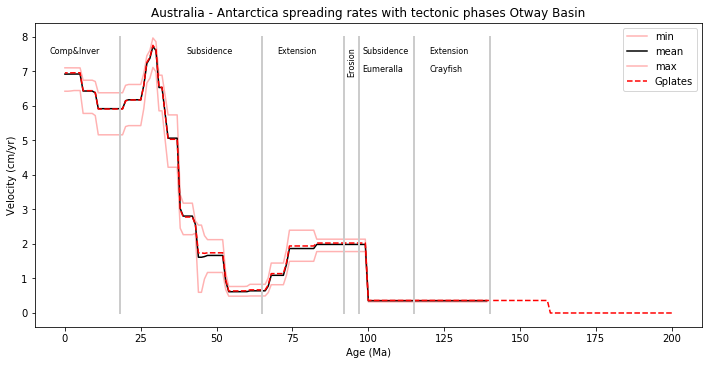

In [10]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Velocity (cm/yr)')
#label=["Victoria", "Central Australia", "NW Australia"]

#for pt in range(npts):
plt.plot(reconstruction_times, vels_matrix[:,0], color=(1, 0, 0,0.3 ), label="min")
plt.plot(reconstruction_times, vels_matrix[:,1], color=(0, 0, 0, 1),label="mean")
plt.plot(reconstruction_times, vels_matrix[:,2],color=(1, 0, 0, 0.3), label="max")
plt.plot(df.Time_Ma, df.V_mag_cm_yr, '--', color=(1, 0, 0, 1), label="Gplates")  
#Adding tectonic phases Otway Basin 
ul=[18,65,92,97,115,140] #These are the ages of the tectonic phases in Ma
#This is not that elegant, it is ploting vertical lines ar a given x from a range in y
for i in range(0,len(ul),1):
    plt.plot([ul[i],ul[i]], [ 0,8],  color=(.8, 0.8, 0.8, ), lw=2)
fs=8
plt.axvline(ul)#try this
plt.text(120,7, "Crayfish", fontsize=fs)
plt.text(120,7.5, "Extension", fontsize=fs)
plt.text(98, 7, "Eumeralla", fontsize=fs)
plt.text(98, 7.5, "Subsidence", fontsize=fs)
plt.text(93, 7.5, "Erosion", fontsize=fs, rotation=90)
plt.text(70, 7.5, "Extension", fontsize=fs)
plt.text(40, 7.5, "Subsidence", fontsize=fs)
plt.text(-5, 7.5, "Comp&Inver", fontsize=fs)
plt.tight_layout()
plt.title("Australia - Antarctica spreading rates with tectonic phases Otway Basin") 
ax.legend()
plt.savefig("./AUAntarctica_spreading_rates&tectonics_OtwayBasin.pdf")